# MNIST Conditional Adversarial AutoEncoder
Implementation of vanilla (no CNN) Conditional Adversarial AutoEncoder. This architecture forces the latent space of an autoencoder to follow a particular distribution, in a way more efficient than Variational AutoEncoders.

In other words it makes a simple autoencoder become a generative model.

The main difference is that we will inject (concatenate) our label information (one-hot) into the latent space on the decoder, no change in loss or anything else.

The main use of this architecture is to augment datasets.

#### Losses
* Reconstruction Loss
* Discriminator Loss
* Generator (encoder) Loss

The adversarial training criterion forces the autoencoder latent follow any particular distribution.

#### References
* [Paper](https://arxiv.org/pdf/1511.05644.pdf)
* https://github.com/neale/Adversarial-Autoencoder
* https://github.com/bfarzin/pytorch_aae
* https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/

In [1]:
import mnist_data_pytorch as data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Pytorch version:', torch.__version__)
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
!rm -rf ./runs
writer = SummaryWriter('./runs/train')

# Metaparameters
num_epochs = 300
num_classes = 10
latent_size = 100
gen_lr = 0.0001
reg_lr = 0.00005
EPS = 1e-15

Device: cuda:0
Pytorch version: 1.2.0


#### Function to convert labels to one-hot

In [2]:
def one_hot(labels, num_classes=10):
    """
    Convert labels to one_hot_encoding
    """
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

print('1: one-hot', one_hot(1))
print('9: one-hot', one_hot(9))

1: one-hot tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
9: one-hot tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


#### Define Encoder/Decoder/Discriminator

In [3]:
class Encoder(nn.Module):  
    def __init__(self, X_dim, z_dim):
        super(Encoder, self).__init__()
        self.lin1 = nn.Linear(X_dim, 1000)
        #self.lin1_bn = nn.BatchNorm1d(1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.latent = nn.Linear(1000, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        z = self.latent(x)
        return z
    

class Decoder(nn.Module):  
    def __init__(self, X_dim, z_dim, num_classes=10):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim + num_classes, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return torch.sigmoid(x)
        #return x
    

class Discriminator(nn.Module):  
    def __init__(self, z_dim):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return torch.sigmoid(self.lin3(x)) 


# Initialize Networks
encoder = Encoder(784, latent_size).to(device)
decoder = Decoder(784, latent_size).to(device)
discriminator = Discriminator(latent_size).to(device)

#### Initialize Optimizers

In [4]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
#regularizing optimizers
optim_encoder_generator = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=reg_lr)

#### Train loop

In [5]:
for epoch in tqdm(range(num_epochs)):
    running_loss_discriminator = 0.0
    running_loss_generator = 0.0
    running_loss_reconstruction = 0.0
    # Iterate over the data
    for idx_sample, (inputs, labels) in enumerate(data.dataloaders['train']):
        inputs = inputs.to(device)
        inputs = torch.flatten(inputs, start_dim=1, end_dim=-1)
        labels = labels.to(device)
        # Convert y to one-hot and send to GPU
        y = one_hot(labels)
        y = y.to(device)
        
        # Zero gradients
        optim_encoder.zero_grad()
        optim_decoder.zero_grad()
        optim_discriminator.zero_grad()
        
        # Concatenate label (one-hot) with latent
        z_sample = encoder(inputs)
        z_sample = torch.cat((y, z_sample), 1)
        
        # Reconstruct X
        inputs_reconstruct = decoder(z_sample)
        reconstruct_loss = F.binary_cross_entropy(inputs_reconstruct + EPS, inputs + EPS)
        #reconstruct_loss = F.mse_loss(inputs_reconstruct + EPS, inputs + EPS)
        
        # Backprop from reconstruction loss
        reconstruct_loss.backward()
        # Optimizer Encoder/Decoder
        optim_encoder.step()
        optim_decoder.step()
        
        # Update statistics
        running_loss_reconstruction += reconstruct_loss.item() * inputs.size(0)
        
        # Discriminator (Force latent space to be the same distribution given)
        ## true prior is random normal (randn)
        ## this is constraining the Z-projection to be normal!
        encoder.eval()
        batch_size = inputs.size()[0]
        z_real_distribution = (torch.randn(batch_size, latent_size) * 1.).to(device)
        D_real_gauss = discriminator(z_real_distribution)

        # Fake images come from encoder(generator)
        z_fake_gauss = encoder(inputs)
        D_fake_gauss = discriminator(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))

        D_loss.backward()
        optim_discriminator.step()
        # Update statistics
        running_loss_discriminator += D_loss.item() * inputs.size(0)

        # Generator
        encoder.train()
        z_fake_gauss = encoder(inputs)
        D_fake_gauss = discriminator(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))

        G_loss.backward()
        optim_encoder_generator.step()   
        # Update statistics
        running_loss_generator += G_loss.item() * inputs.size(0)
    
    # Epoch ends
    epoch_loss_generator = running_loss_generator / len(data.dataloaders['train'].dataset)
    epoch_loss_discriminator = running_loss_discriminator / len(data.dataloaders['train'].dataset)
    epoch_loss_reconstruction = running_loss_reconstruction / len(data.dataloaders['train'].dataset)
    
    # Send results to tensorboard
    writer.add_scalar('train/loss_generator', epoch_loss_generator, epoch)
    writer.add_scalar('train/loss_discriminator', epoch_loss_discriminator, epoch)
    writer.add_scalar('train/reconstruction', epoch_loss_reconstruction, epoch)
    
    # Send images to tensorboard
    writer.add_images('train/decoder_images', inputs_reconstruct.view(inputs.size(0),1,28,28), epoch)
    writer.add_images('train/input_images', inputs.view(inputs.size(0),1,28,28), epoch)
    
    # Send latent to tensorboard
    writer.add_histogram('train/latent', z_sample, epoch)
    writer.add_histogram('train/distribution', z_real_distribution, epoch)
    writer.add_histogram('train/input_images_h', inputs, epoch)
    

100%|██████████| 300/300 [14:29<00:00,  2.90s/it]


#### Generate Samples (Unconditioned)
Observe that the generated samples are somehow a mix of all classes.

In [28]:
def generate_sample(num_idx=0, category=0):
    decoder.eval()
    # Observe that we had to make the labels 10x bigger
    one_hot_category = one_hot([category]).to(device) * 10
    z_real_gauss = (torch.randn(1, latent_size) * 1.).to(device)
    z_real_gauss = torch.cat((one_hot_category, z_real_gauss), 1)
    with torch.no_grad(): 
        generated_sample = decoder(z_real_gauss)

    plt.imshow(generated_sample.view(28,28).cpu().numpy())
    plt.title('Generated sample')
    plt.show()

In [29]:
interact(generate_sample, num_idx=widgets.IntSlider(min=0, max=100, step=1, value=0), category = [x for x in range(10)]);

interactive(children=(IntSlider(value=0, description='num_idx'), Dropdown(description='category', options=(0, …

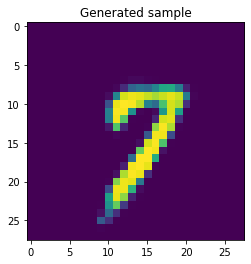

In [30]:
generate_sample(0,7)